In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image

import torch
import torch.nn as nn
import cv2

---

## Data load

In [271]:
from collections import defaultdict


def parse_activities(string: str) -> list[str]:
    while string.find(r"(") >= 0:
        first_br = string.find(r"(")
        if (first_br > 0):
            second_br = string.find(r")")
            if second_br > 0:
                string = string[:first_br] + string[second_br+2:]
            else:
                string = string[:first_br]

    return [sub.strip() for sub in string.split(',')]


def get_activities(df: pd.DataFrame):
    categories = set(df['Category'].unique())

    activities = set()
    for _, row in df.iterrows():
        row_activities = parse_activities(row['Activity'])
        activities.update(row_activities)

    categories = list(categories)
    activities = list(activities)

    cat2act = {i: set() for i in range(len(categories))}
    for _, row in df.iterrows():
        row_activities = parse_activities(row['Activity'])
        row_category = row['Category']
        cat2act[categories.index(row_category)].update([activities.index(i) for i in row_activities])

    return np.array(categories), \
           np.array(activities), \
           {i: sorted(np.array(list(st))) for i, st in cat2act.items()}

In [272]:
cat, act, cat2act = get_activities(pd.read_csv('./var_13.csv'))

intersections = defaultdict(set)
for cat_idx1, act_idxs1 in cat2act.items():
    for cat_idx2, act_idxs2 in cat2act.items():
        if cat_idx1 != cat_idx2:
            inter = set(act_idxs1) & set(act_idxs2)
            if len(inter) > 0:
                for a in inter:
                    if len(intersections) == 0:
                        intersections[a] = set([cat_idx1, cat_idx2])
                    elif set([cat_idx1, cat_idx2]) not in intersections.values():
                        intersections[a].update(set([cat_idx1, cat_idx2]))

print("Пересекающиеся активности:")
for a, c in intersections.items():
    cats = ', '.join([f"'{cat[i]}'" for i in c])
    print(f"   \'{act[a]}\' -> {cats}")

Пересекающиеся активности:
   'general' -> 'sports', 'walking', 'bicycling', 'home activities', 'occupation', 'winter activities', 'home repair'
   'standing' -> 'miscellaneous', 'occupation'
   'bicycling' -> 'bicycling', 'conditioning exercise'
   'moderate effort' -> 'home activities', 'lawn and garden'
   'carpentry' -> 'home repair', 'occupation'
   'rowing' -> 'water activities', 'conditioning exercise'


In [275]:
from torch.utils.data import Dataset


keypoints_cols = ['r ankle_X', 'r ankle_Y', 'r knee_X', 'r knee_Y', 'r hip_X', 'r hip_Y', 'l hip_X', 'l hip_Y', 
                  'l knee_X', 'l knee_Y', 'l ankle_X', 'l ankle_Y', 'pelvis_X', 'pelvis_Y', 'thorax_X', 'thorax_Y', 
                  'upper neck_X', 'upper neck_Y', 'head top_X', 'head top_Y', 'r wrist_X', 'r wrist_Y', 'r elbow_X', 'r elbow_Y', 
                  'r shoulder_X', 'r shoulder_Y', 'l shoulder_X', 'l shoulder_Y', 'l elbow_X', 'l elbow_Y', 'l wrist_X', 'l wrist_Y']

class BodyKeypointsDataset(Dataset):
    def __init__(self, csv_path, root_dir, transform=None):
        self.dataframe = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform

        self.catecories, self.activities, self.cat2actIds = get_activities(self.dataframe)
        self.output_size = len(self.activities)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.loc[idx, 'NAME'])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        landmarks = self.dataframe.loc[idx, keypoints_cols]
        landmarks = np.array([landmarks], dtype=np.float32).reshape(-1, 2)

        row_activities = parse_activities(self.dataframe.loc[idx, 'Activity'])
        activities = np.array([1.0 if act in row_activities else 0.0 for act in self.activities], dtype=np.float32)

        sample = {'image': image, 'landmarks': landmarks, 'target': activities}

        if self.transform:
            sample = self.transform(sample)

        return sample

1) Image size: (720, 1280, 3), Landmarks: (16, 2)
2) Image size: (1080, 1920, 3), Landmarks: (16, 2)
3) Image size: (720, 1280, 3), Landmarks: (16, 2)
4) Image size: (720, 1280, 3), Landmarks: (16, 2)
5) Image size: (1080, 1920, 3), Landmarks: (16, 2)
6) Image size: (1080, 1920, 3), Landmarks: (16, 2)
7) Image size: (720, 1280, 3), Landmarks: (16, 2)
8) Image size: (720, 1280, 3), Landmarks: (16, 2)
9) Image size: (720, 1280, 3), Landmarks: (16, 2)


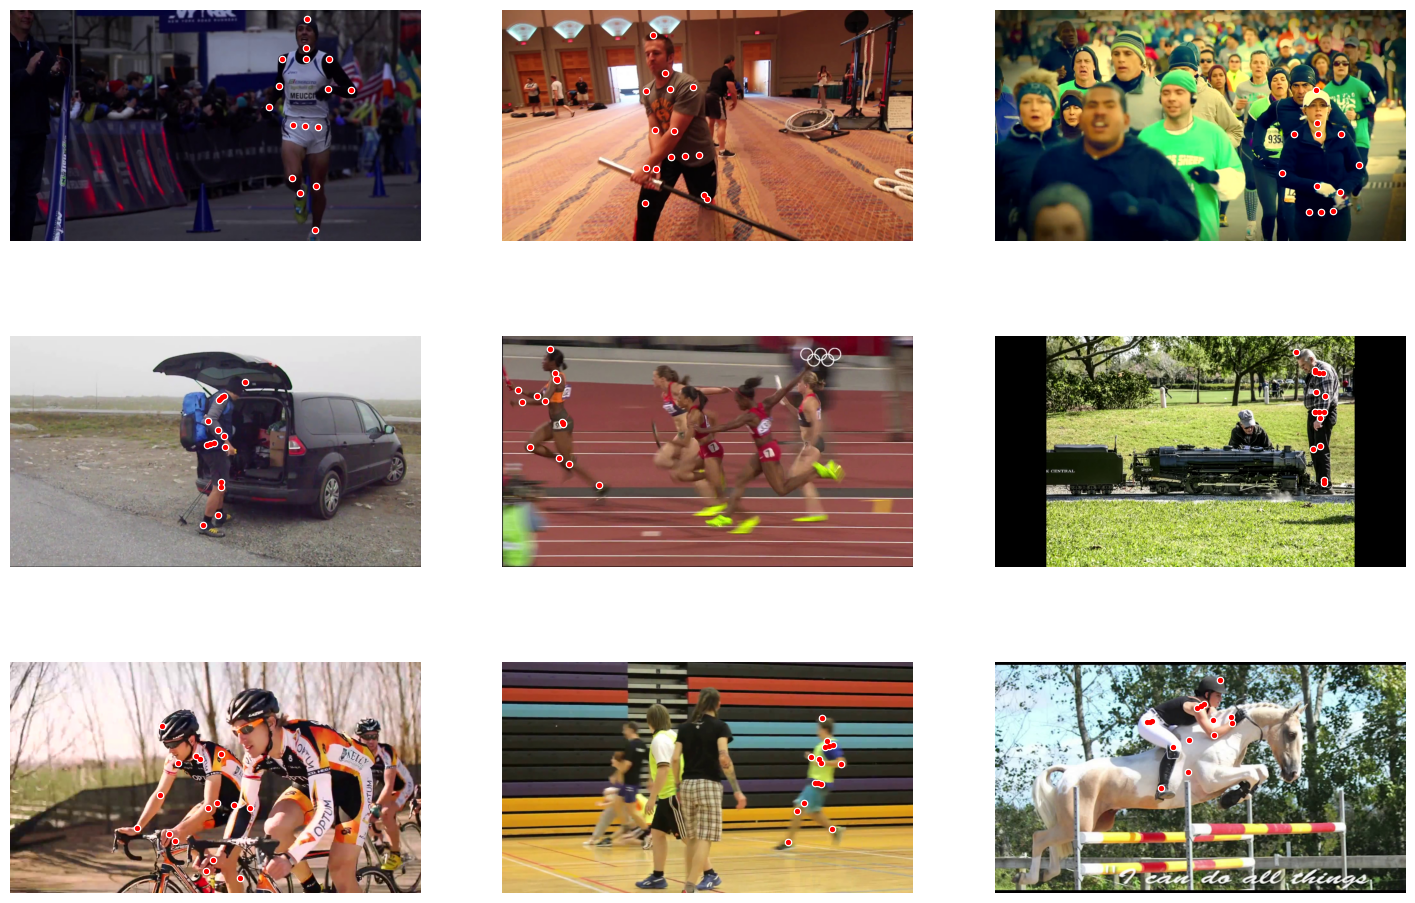

In [276]:
dataset = BodyKeypointsDataset(csv_path='./var_13.csv', root_dir='./dataset/')


def show_landmarks(image, landmarks, r=30):
    plt.imshow(image)
    xs = [x for x in landmarks[:, 0] if x >= 0]
    ys = [y for y in landmarks[:, 1] if y >= 0]
    plt.scatter(xs, ys, s=r+50, marker='.', c='w')
    plt.scatter(xs, ys, s=r, marker='.', c='r')


plt.figure(figsize=(18, 12), frameon=False)
for i, sample_idx in enumerate(np.random.choice(len(dataset), size=9)):
    sample = dataset[sample_idx]
    print(f"{i+1}) Image size: {sample['image'].shape}, Landmarks: {sample['landmarks'].shape}")

    plt.subplot(3, 3, i + 1)
    show_landmarks(sample['image'], sample['landmarks'])
    plt.axis('off')

---

## Transform

In [277]:
from skimage import transform

In [323]:
from torchvision import transforms

class Rescale:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks, 'target': sample['target']}

class RandomCrop:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size


    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks, 'target': sample['target']}

class SquareCropAndResize:
    def __init__(self, output_size: int):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size, self.output_size

        over_w = new_w - w
        over_h = new_h - h
        if over_w > 0 or over_h > 0:
            if over_w > over_h:
                image = transform.resize(image, (int(self.output_size * h / w), new_w))
            else:
                image = transform.resize(image, (new_h, int(self.output_size * w / h)))
            landmarks = landmarks * [image.shape[1] / w, image.shape[0] / h]
            h, w = image.shape[:2]

        xs = [x for x in landmarks[:, 0] if x >= 0]
        ys = [y for y in landmarks[:, 1] if y >= 0]
        cx, cy = int(sum(xs) / len(xs)), int(sum(ys) / len(ys))

        top = int(cy - new_h / 2)
        left = int(cx - new_w / 2)
        bottom = int(cy + new_h / 2)
        right = int(cx + new_w / 2)

        y_offset = 0
        if top < 0: y_offset = -top
        elif bottom > h: y_offset = h - bottom
        
        x_offset = 0
        if left < 0: x_offset = -left
        elif right > w: x_offset = w - right

        left = int(left + x_offset)
        right = int(right + x_offset)
        top = int(top + y_offset)
        bottom = int(bottom + y_offset)
        # print(top, bottom, left, right, "Shape: ", image.shape[:2], "CoM: ", (int(cy), int(cx)), "Offset: ", (y_offset, x_offset))

        image = image[top: bottom, left: right]

        landmarks = landmarks - [left, top]
        landmarks = np.array([key if key[0] >= 0 and key[0] <= new_w and key[1] >= 0 and key[1] <= new_h else [-1, -1] for key in landmarks])

        return {'image': image, 'landmarks': landmarks, 'target': sample['target']}
    


class ToTensor:
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 
                'landmarks': torch.from_numpy(landmarks), 
                'target': torch.from_numpy(sample['target'])}
    
class Normalize:
    def __init__(self, output_size: int):
        assert isinstance(output_size, int)
        self.output_size = output_size

        # self.image_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                                             std=[0.229, 0.224, 0.225])

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': image / 255, 
                'landmarks': landmarks / self.output_size, 
                'target': sample['target']}

In [324]:
composed = transforms.Compose([SquareCropAndResize(640)])

dataset = BodyKeypointsDataset(csv_path='./var_13.csv',
                                    root_dir='./dataset/',
                                    transform=composed)

1) Image size: (640, 640, 3), Landmarks: (16, 2)
2) Image size: (640, 640, 3), Landmarks: (16, 2)
3) Image size: (640, 640, 3), Landmarks: (16, 2)
4) Image size: (640, 640, 3), Landmarks: (16, 2)
5) Image size: (640, 640, 3), Landmarks: (16, 2)
6) Image size: (640, 640, 3), Landmarks: (16, 2)
7) Image size: (640, 640, 3), Landmarks: (16, 2)
8) Image size: (640, 640, 3), Landmarks: (16, 2)
9) Image size: (640, 640, 3), Landmarks: (16, 2)


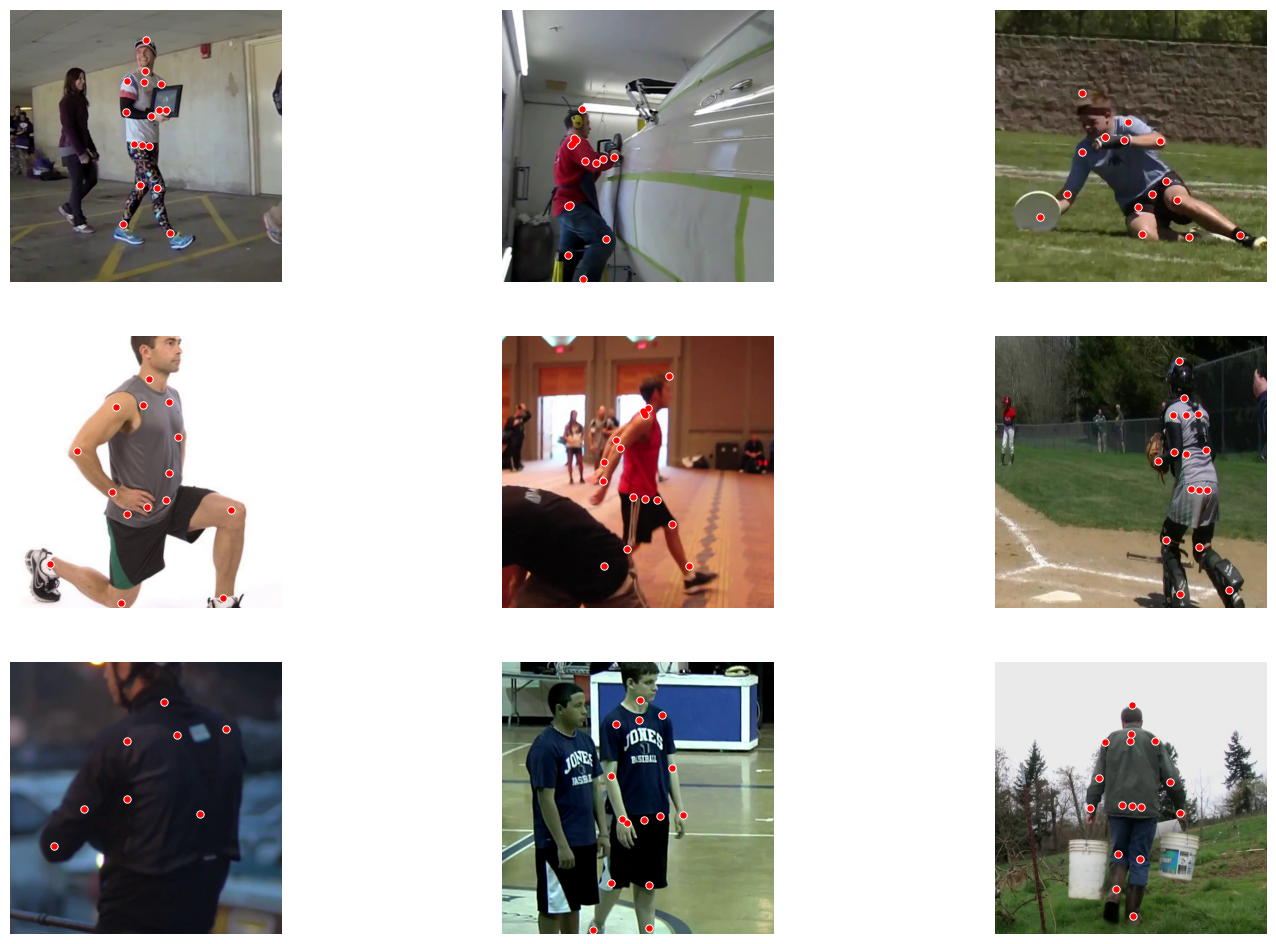

In [325]:
plt.figure(figsize=(18, 12), frameon=False)
for i, sample_idx in enumerate(np.random.choice(len(dataset), size=9)):
    sample = dataset[sample_idx]
    print(f"{i+1}) Image size: {sample['image'].shape}, Landmarks: {sample['landmarks'].shape}")

    plt.subplot(3, 3, i + 1)
    show_landmarks(sample['image'], sample['landmarks'], r=50)
    plt.axis('off')

---

## Prepare final dataset

In [326]:
composer = transforms.Compose([SquareCropAndResize(224), 
                               Normalize(224),
                               ToTensor()])

final_dataset = BodyKeypointsDataset(csv_path='./var_13.csv',
                                    root_dir='./dataset/',
                                    transform=composer)

print(len(final_dataset))

789


In [367]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader


train_set, val_set = random_split(final_dataset, [650, 139])

batch_size = 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

---

## Model design

In [461]:
import torch.nn.functional as F
import timm

features_input_size = len(keypoints_cols) // 2
output_size = len(dataset.activities)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.vit = timm.create_model('google/vit_base_patch16_224', pretrained=True)
        self.vit.requires_grad_(False)
        self.vit.head = nn.Linear(self.vit.head.in_features, 512)
        self.vit.head.requires_grad_(True)

        self.relu = nn.ReLU(inplace=True)

        self.input_layer = nn.Linear(2, batch_size*4)
        self.headen_layer = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, output_size)
        
    def forward(self, image, features):
        x1 = self.vit(image)
        x1 = self.relu(x1)
        x2 = self.input_layer(features)
        x2 = self.relu(x2)

        N, _, _ = x2.size()
        x2 = x2.view(N,-1)

        x = torch.cat((x1, x2), 1)

        x = self.headen_layer(x)
        x = self.relu(x)


        x = self.output_layer(x)
        x = self.relu(x)
        return x

In [462]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [463]:
model = Model()
if use_gpu:
    model = model.cuda()

In [464]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)

In [471]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(y_valid, y_pred,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_valid, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [488]:
from  torch.autograd import Variable
import time

def train_model(model, criterion, optimizer, show_confusion_matrix = True, num_epochs=5):
    since = time.time()

    best_acc = 0.0
    best_lbl_prd = []
    best_lbl_tru = []
        
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:   
            loader = train_loader
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
                loader = val_loader 
            
            running_loss = 0.0
            running_corrects = 0

            lbl_prd_val = [] 
            lbl_tru_val = []

            for batch in loader:
                    
                image_input = batch['image']  
                landmarks_input = batch['landmarks']
                labels_output = batch['target']
                
                if use_gpu:
                    image_input = Variable(image_input.float().cuda())
                    landmarks_input = Variable(landmarks_input.float().cuda())
                    labels_output = Variable(labels_output.float().cuda())
                else:
                    image_input = Variable(image_input)
                    landmarks_imput = Variable(landmarks_imput)
                    labels_output = Variable(labels_output)
                    
                optimizer.zero_grad()

                outputs = model(image_input , landmarks_input)
                _, preds = torch.max(outputs.data, 1)
                
                loss = criterion(outputs, labels_output)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                    lbl_tru_val = np.concatenate((lbl_tru_val, labels_output.data.cpu().numpy()), 0)
                    lbl_prd_val = np.concatenate((lbl_prd_val, preds.cpu().numpy()), 0)    
                running_loss += loss.data.item()
                running_corrects += torch.sum(preds == labels_output.data)
                
            if phase =='train':
                len_dataset = len(train_set)
            else:
                len_dataset = len(val_set)

            epoch_loss = running_loss / (len_dataset / 2)
            epoch_acc = running_corrects / (len_dataset / 2)
            
            if phase == 'val':
                if best_acc < epoch_acc:
                    best_acc = epoch_acc
                    best_lbl_prd = lbl_prd_val
                    best_lbl_tru = lbl_tru_val
                    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    #show confusion matrix 
    if show_confusion_matrix:
        plot_confusion_matrix(best_lbl_tru, best_lbl_prd, dataset.activities)
        
    return model

In [489]:
trained_model = train_model(model, criterion, optimizer)

Epoch 0/4
----------
train Loss: 1.9563 Acc: 169.2492


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)